# Importing Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [2]:
df_ = pd.read_csv("/content/flo_data_20k.csv")
df = df_.copy()
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN]
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]"
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]"
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]"
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR]


In [3]:
df.isnull().sum().sum()

0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 12 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   master_id                          19945 non-null  object 
 1   order_channel                      19945 non-null  object 
 2   last_order_channel                 19945 non-null  object 
 3   first_order_date                   19945 non-null  object 
 4   last_order_date                    19945 non-null  object 
 5   last_order_date_online             19945 non-null  object 
 6   last_order_date_offline            19945 non-null  object 
 7   order_num_total_ever_online        19945 non-null  float64
 8   order_num_total_ever_offline       19945 non-null  float64
 9   customer_value_total_ever_offline  19945 non-null  float64
 10  customer_value_total_ever_online   19945 non-null  float64
 11  interested_in_categories_12        19945 non-null  obj

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_num_total_ever_online,19945.0,3.110855,4.225647,1.00,1.00,2.00,4.00,200.00
order_num_total_ever_offline,19945.0,1.913913,2.062880,1.00,1.00,1.00,2.00,109.00
customer_value_total_ever_offline,19945.0,253.922597,301.532853,10.00,99.99,179.98,319.97,18119.14
customer_value_total_ever_online,19945.0,497.321690,832.601886,12.99,149.98,286.46,578.44,45220.13


## Feature Selection

In [6]:
date_columns= ["first_order_date", "last_order_date", "last_order_date_online", "last_order_date_offline"]
for date in date_columns:
    df[date]  = pd.to_datetime(df[date])

In [8]:
df["first_order_date"].min(), df["last_order_date"].max(),

(Timestamp('2013-01-14 00:00:00'), Timestamp('2021-05-30 00:00:00'))

In [9]:
today = dt.datetime(2021, 6, 1)
df["recency"] = [(today - date).days for date in df["last_order_date"]]
df["frequency"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"]
df["monetary"] = df["customer_value_total_ever_offline"] + df["customer_value_total_ever_online"]
df["monetary_avg"] = df["monetary"] / df["frequency"]
df["tenure"] = df["first_order_date"].apply(lambda x: (today - x).days )/7 # Dividing 7 because Weekly

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,recency,frequency,monetary,monetary_avg,tenure
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],95,5.0,939.37,187.874000,30.571429
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",105,21.0,2013.55,95.883333,224.857143
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",186,5.0,585.32,117.064000,78.857143
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",135,2.0,121.97,60.985000,20.857143
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],86,2.0,209.98,104.990000,95.428571


In [10]:
dff = df[["recency", "frequency", "monetary", "monetary_avg", "tenure"]]

# Scaling


In [11]:
ss = StandardScaler()
dff_scaled = ss.fit_transform(dff)
dff = pd.DataFrame(dff_scaled, columns= dff.columns)
dff.head()

,recency,frequency,monetary,monetary_avg,tenure
0,-0.382058,-0.005222,0.210107,0.424836,-1.122127
1,-0.285232,3.368463,1.409799,-0.676825,1.476349
2,0.499055,-0.005222,-0.185312,-0.423170,-0.476329
3,0.005244,-0.637788,-0.702802,-1.094760,-1.252050
4,-0.469201,-0.637788,-0.604508,-0.567765,-0.254694


# K-Means Model

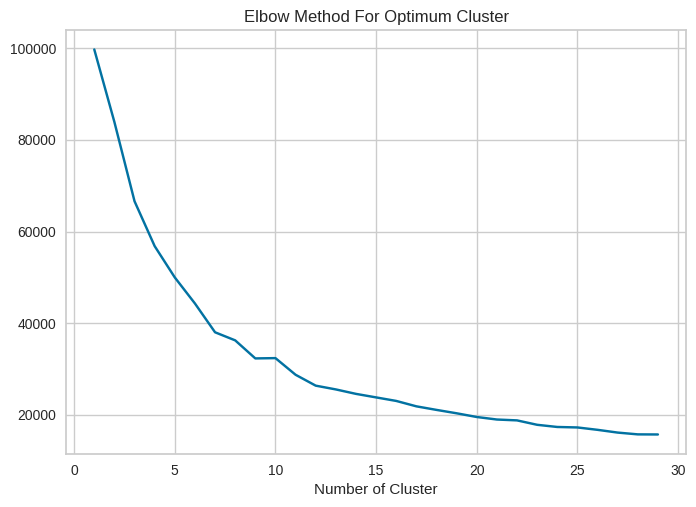

In [15]:
kmeans = KMeans()
ssd = []
K = range(1,30)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(dff)
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, "bx-")
plt.xlabel("Number of Cluster")
plt.title("Elbow Method For Optimum Cluster")
plt.show()

## Optimum Number of Cluster, Elbow Method

In [13]:
!pip install kneed

In [17]:
from kneed import KneeLocator
kneedle = KneeLocator(K, ssd, curve="convex", direction="decreasing")
print("Best k:", kneedle.elbow)

elbow_points = kneedle.all_elbows
print("Other k points:", elbow_points)

Best k: 9
Other k points: {9}


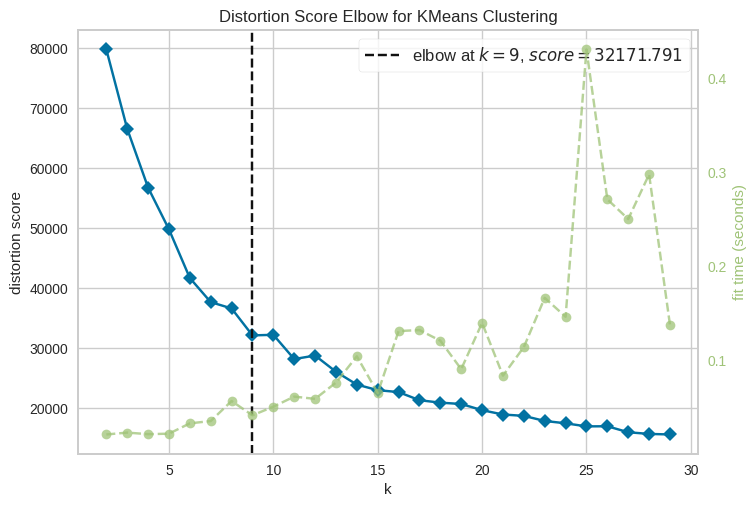

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k= (2,30))
elbow.fit(dff)
elbow.show()

In [19]:
elbow.elbow_value_

9


# Customer Segmentation

In [20]:
kmeans = KMeans(n_clusters= kneedle.elbow).fit(dff)
print(kmeans.n_clusters)
print(kmeans.cluster_centers_)
print(kmeans.labels_)

9
[[-5.78539232e-01 -2.77649524e-01 -3.89060865e-01 -5.16379260e-01
  -3.73982261e-01]
 [-5.27139572e-01  1.10032381e+00  8.58847513e-01 -7.21384556e-03
   2.48181811e-01]
 [ 6.48442303e-03 -2.44254484e-01  7.08192035e-01  2.55851065e+00
  -4.56577819e-01]
 [-5.69739994e-01 -2.95342852e-01 -1.72456642e-02  6.47397219e-01
  -4.93982706e-01]
 [-6.69767729e-01  2.10501889e+01  2.70293302e+01  1.38237010e+00
   1.78669230e+00]
 [ 1.26069751e+00 -2.96125144e-01 -2.99848307e-01 -2.15248123e-01
  -1.92904772e-01]
 [-3.64342674e-01  4.19021739e+00  3.25149570e+00  6.57524668e-02
   1.56919973e+00]
 [-8.95232863e-01  5.21915851e-01  2.81619406e+01  4.61704878e+01
  -1.39057205e+00]
 [ 2.58677056e-01  2.30191705e-01  4.69035703e-03 -3.08092262e-01
   2.39850029e+00]]
[3 6 5 ... 3 3 5]


In [21]:
cluster_kmeans = kmeans.labels_
df["clusters"] = cluster_kmeans
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,recency,frequency,monetary,monetary_avg,tenure,clusters
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],95,5.0,939.37,187.874000,30.571429,3
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",105,21.0,2013.55,95.883333,224.857143,6
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",186,5.0,585.32,117.064000,78.857143,5
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",135,2.0,121.97,60.985000,20.857143,0
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],86,2.0,209.98,104.990000,95.428571,0



## Statistical Analysis of Clusters

In [22]:
df.groupby("clusters").agg({"recency":["count","mean", "median"],
                            "frequency":["mean", "median"],
                            "monetary":["mean", "median"],
                            "monetary_avg":["mean", "median"],
                            "tenure":["mean", "median"]})

recency                      frequency             monetary  \
           count        mean median        mean median          mean   
clusters                                                               
0           6088   74.657030   70.0    3.711399    3.0    403.350069   
1           2035   80.188206   62.0   10.260442   10.0   1524.487759   
2            898  135.128062  124.0    3.866370    3.0   1385.345078   
3           3663   75.610429   64.0    3.625444    3.0    736.017551   
4              7   65.285714   32.0  104.857143   82.0  24952.758571   
5           5048  264.645008  258.0    3.620246    3.0    482.725820   
6            398   96.927136   66.5   24.922111   22.0   3662.156181   
7              2   42.000000   42.0    7.500000    7.5  25966.875000   
8           1806  160.977298  147.0    6.117940    5.0    755.606960   

                    monetary_avg                   tenure              
             median         mean       median        mean      median  
clusters                                                               
0           369.400   109.301951   110.132250   86.540806   87.285714  
1          1408.000   151.984576   147.980000  132.936469  118.428571  
2          1186.905   366.039799   339.520833   80.333917   79.000000  
3           691.830   206.458022   199.955000   77.555049   79.428571  
4         18443.570   267.829895   241.693857  248.061224  211.857143  
5           421.935   134.417623   128.747500  100.038912   92.428571  
6          3281.435   157.645682   141.859942  232.162240  228.857143  
7         25966.875  4007.720227  4007.720227   10.500000   10.500000  
8           664.665   126.664008   117.996667  293.674498  293.285714

# Hiearchical Clustering

In [23]:
dff.head()

,recency,frequency,monetary,monetary_avg,tenure
0,-0.382058,-0.005222,0.210107,0.424836,-1.122127
1,-0.285232,3.368463,1.409799,-0.676825,1.476349
2,0.499055,-0.005222,-0.185312,-0.423170,-0.476329
3,0.005244,-0.637788,-0.702802,-1.094760,-1.252050
4,-0.469201,-0.637788,-0.604508,-0.567765,-0.254694


In [29]:
hc_average = linkage(dff, "average")
hc_complete = linkage(dff, "complete")
hc_single = linkage(dff, "single")
hc_ward = linkage(dff, "ward")

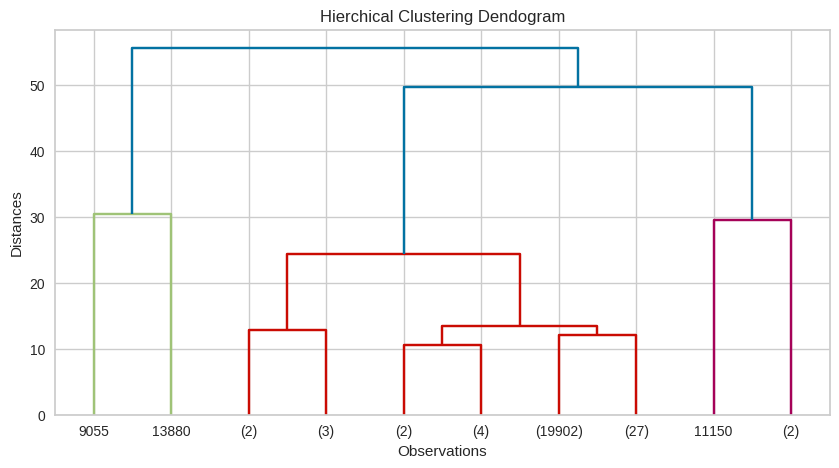

In [25]:
plt.figure(figsize=(10,5))
plt.title("Hierchical Clustering Dendogram")
plt.xlabel("Observations")
plt.ylabel("Distances")
dendrogram(hc_average,
           truncate_mode="lastp",
           p=10,
           show_contracted=False,
           leaf_font_size=10)
plt.show()

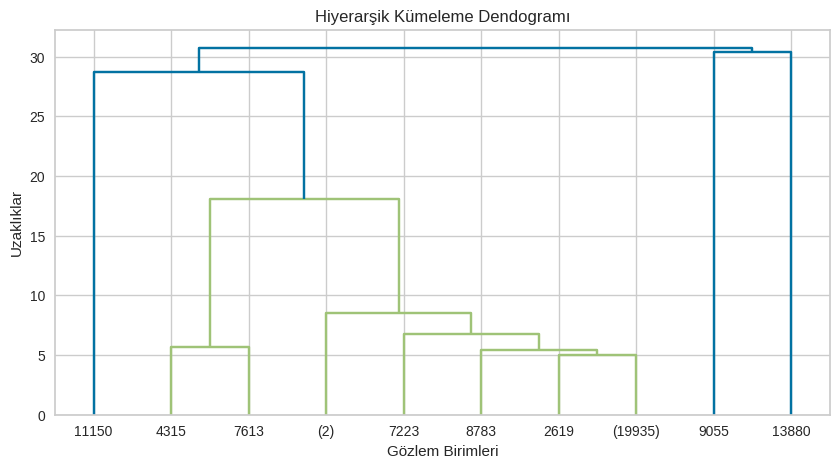

In [26]:
plt.figure(figsize=(10,5))
plt.title("Hiyerarşik Kümeleme Dendogramı")
plt.xlabel("Gözlem Birimleri")
plt.ylabel("Uzaklıklar")
dendrogram(hc_single,
           truncate_mode="lastp",
           p=10,
           show_contracted=False,
           leaf_font_size=10)
plt.show()

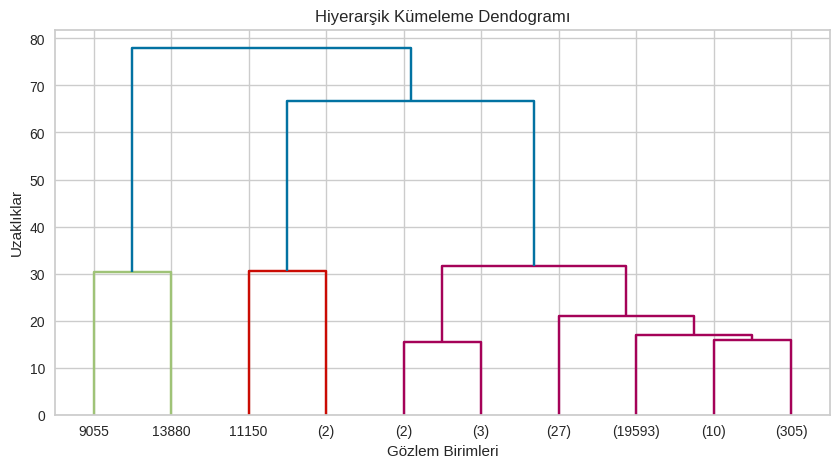

In [27]:
plt.figure(figsize=(10,5))
plt.title("Hiyerarşik Kümeleme Dendogramı")
plt.xlabel("Gözlem Birimleri")
plt.ylabel("Uzaklıklar")
dendrogram(hc_complete,
           truncate_mode="lastp",
           p=10,
           show_contracted=False,
           leaf_font_size=10)
plt.show()

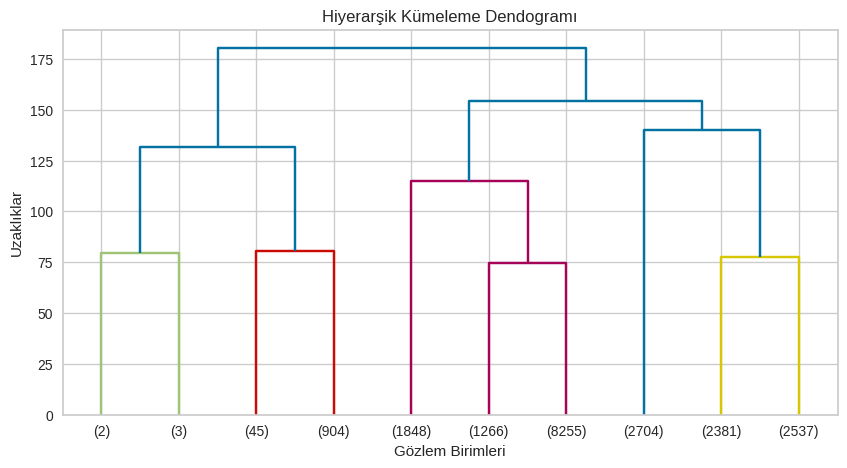

In [30]:
plt.figure(figsize=(10,5))
plt.title("Hiyerarşik Kümeleme Dendogramı")
plt.xlabel("Gözlem Birimleri")
plt.ylabel("Uzaklıklar")
dendrogram(hc_ward,
           truncate_mode="lastp",
           p=10,
           show_contracted=False,
           leaf_font_size=10)
plt.show()

In [31]:
from sklearn.cluster import AgglomerativeClustering

In [32]:
h_cluster = AgglomerativeClustering(n_clusters=10, linkage="ward")
h_cluster = h_cluster.fit_predict(dff)

In [33]:
df["h_cluster"] = h_cluster
df.head()

,master_id,order_channel,last_order_channel,first_order_date,last_order_date,last_order_date_online,last_order_date_offline,order_num_total_ever_online,order_num_total_ever_offline,customer_value_total_ever_offline,customer_value_total_ever_online,interested_in_categories_12,recency,frequency,monetary,monetary_avg,tenure,clusters,h_cluster
0,cc294636-19f0-11eb-8d74-000d3a38a36f,Android App,Offline,2020-10-30,2021-02-26,2021-02-21,2021-02-26,4.0,1.0,139.99,799.38,[KADIN],95,5.0,939.37,187.874000,30.571429,3,1
1,f431bd5a-ab7b-11e9-a2fc-000d3a38a36f,Android App,Mobile,2017-02-08,2021-02-16,2021-02-16,2020-01-10,19.0,2.0,159.97,1853.58,"[ERKEK, COCUK, KADIN, AKTIFSPOR]",105,21.0,2013.55,95.883333,224.857143,6,4
2,69b69676-1a40-11ea-941b-000d3a38a36f,Android App,Android App,2019-11-27,2020-11-27,2020-11-27,2019-12-01,3.0,2.0,189.97,395.35,"[ERKEK, KADIN]",186,5.0,585.32,117.064000,78.857143,5,1
3,1854e56c-491f-11eb-806e-000d3a38a36f,Android App,Android App,2021-01-06,2021-01-17,2021-01-17,2021-01-06,1.0,1.0,39.99,81.98,"[AKTIFCOCUK, COCUK]",135,2.0,121.97,60.985000,20.857143,0,1
4,d6ea1074-f1f5-11e9-9346-000d3a38a36f,Desktop,Desktop,2019-08-03,2021-03-07,2021-03-07,2019-08-03,1.0,1.0,49.99,159.99,[AKTIFSPOR],86,2.0,209.98,104.990000,95.428571,0,1


## Statistical Analysis of Clusters

In [34]:
df.loc[df["h_cluster"]==3, "h_cluster"] = 6
df.loc[df["h_cluster"]==7, "h_cluster"] = 6
df.loc[df["h_cluster"]==8, "h_cluster"] = 3
df.loc[df["h_cluster"]==9, "h_cluster"] = 7

In [35]:
df.groupby("h_cluster").agg({"recency":["count","mean", "median"],
                            "frequency":["mean", "median"],
                            "monetary":["mean", "median"],
                            "monetary_avg":["mean", "median"],
                            "tenure":["mean", "median"]})

recency                     frequency            monetary            \
            count        mean median       mean median         mean    median   
h_cluster                                                                       
0            2704  154.734837  130.0   5.618343    5.0   691.398047   626.985   
1            8255   91.256208   84.0   3.570442    3.0   433.813743   394.970   
2            1848   55.237554   37.0   4.114177    4.0  1138.682127   969.190   
3            2381  299.112558  308.0   3.461571    3.0   402.888967   344.020   
4             904  104.602876   77.5  16.855088   16.0  2547.040277  2324.770   
5            2537  210.111549  198.0   3.976350    3.0   830.825388   728.700   
6              50  108.360000   73.5  54.720000   48.0  9132.218800  5810.750   
7            1266   49.566351   40.0   9.199842    9.0  1265.712464  1191.075   

          monetary_avg                  tenure              
                  mean      median        mean      median  
h_cluster                                                   
0           126.289796  116.751905  250.087806  235.285714  
1           123.133532  120.653333   80.652765   83.571429  
2           286.250368  259.978333   74.749382   78.571429  
3           115.024822  113.922500   96.259255   92.285714  
4           154.769625  142.829610  217.337705  213.642857  
5           215.689384  207.145000   94.216003   89.857143  
6           298.082434  131.075548  234.962857  197.642857  
7           139.626721  141.596692   99.950350   98.571429